This notbook shows how to implement multi-label classification on protein function prediction with the baseline models. This file also includes the part of data process and integration. 

In [ ]:
!pip install category_encoders
!pip install Bio
!pip install transformers
!pip install tensorflow_addons
!pip install dgl

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
%matplotlib inline
import matplotlib.pyplot as plt
import math,random,re
import time
import torch.optim as optim
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import itertools
import dgl
from dgl.nn import GraphConv
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer,OneHotEncoder,MinMaxScaler
from category_encoders import BinaryEncoder
from tensorflow.keras.models import Sequential, Model
from keras.layers import Embedding, SpatialDropout1D, concatenate
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Dropout, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, Lambda, Layer, Reshape, Flatten, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from keras.layers.core import Flatten
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,multilabel_confusion_matrix
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l1_l2

# Data Input

In [ ]:
! pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CIS522_Final_Project/data_cleaned.csv')
data['splitted_go_labels'] = data['splitted_go_labels'].apply(eval)
data['interactors'] = data['interactors'].apply(eval)

There are total 66841 unique protein sequence, and 24266 labels

In [ ]:
data.head()

,entry,splitted_go_labels,go_labels,sequence,stringid,organismid,interactors
0,A0A024RBG1,"[GO:0005634, GO:0005737, GO:0005829]",GO:0000298; GO:0003723; GO:0005634; GO:0005737...,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,9606.ENSP00000338352,9606,"[NUDT22, NUDT17, NUDT12, NUDT18, NUDT5]"
1,A0A061FBW2,"[GO:0005634, GO:0005737]",GO:0005634; GO:0005737; GO:0008757; GO:0030795...,MEVMQVLHMNKGNGETSYAKNSTVQSKIISVGKPIIEEAVHEISCN...,3641.EOY14825,3641,"[EOY14651, EOY30281, EOY24082, EOX94195, EOY33..."
2,A0A061FDP1,"[GO:0005634, GO:0005737]",GO:0005634; GO:0005737; GO:0008757; GO:0030795...,MEVMQVLHMNRGNGENSYAKNSTVQSKIISIGKPIIEEAVHEISCN...,3641.EOY14822,3641,"[EOY14651, EOY30281, EOY24082, EOX94195, EOY33..."
3,A0A075B734,[GO:0005886],GO:0005886; GO:0006833; GO:0015204; GO:0015250...,MVQASGHRRSTRGSKMVSWSVIAKIQEIWCEEDERKMVREFLAEFM...,9606.ENSP00000456868,9606,"[AQP8, ENSP00000421315, AQP12A, AQP12B, DIP2C]"
4,A0A075B759,"[GO:0005737, GO:0043231]",GO:0000413; GO:0003755; GO:0005737; GO:0006457...,MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,9606.ENSP00000463419,9606,"[NBPF12, RAB28, ACAD10, RPS3A, AIFM1]"


In [ ]:
data.shape

(92135, 7)

# Data processing

## Interactors(Protein interactors)

We have 75 unique interactors. The reason to select binary encoding is that it uses fewer binary columns to represent the same information. A value of 1 indicates that the interactor is present for a given sequence, and 0 indicates its absence. 

In [ ]:
for i in range(data.shape[0]):
    if data['interactors'][i] == ['NaN']:
       data.at[i, 'interactors'] = ['']

In [ ]:
encoder = BinaryEncoder()
interactor_id_encoded = encoder.fit_transform(data['interactors'].apply(pd.Series))
interactor_id_encoded_arr = np.array(interactor_id_encoded)

In [ ]:
interactor_id_encoded_arr.shape

(92135, 75)

## One-hot encoding 

We firstly try the one-hot encoding, which is one of the most used common methods in current protein function prediction papers.

 When we convert categorical data into numerical data using one-hot encoding, we can use mathematical operations on the encoded values. it can prevents the model from assuming a numerical order or relationship between categorical values that may not exist.

### Drop the lower case in sequence
First, drop the lower case base in the sequence since we only want to find the sequences that align

In [ ]:
for index, row in data.iterrows():
     data.at[index, 'sequence'] = ''.join(c for c in row['sequence'] if c.isupper())

### Use the order key to convert label to binary representation

In [ ]:
ORDER_KEY="ACDEFGHIKLMNPQRSTVYWXBUZ"
ORDER_LIST=list(ORDER_KEY)

In [ ]:
oh_encoder = LabelEncoder().fit(ORDER_LIST)
encoded_sequences = np.array([oh_encoder.transform(list(seq)) for seq in data.sequence])

<ipython-input-10-73f921c36617>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded_sequences = np.array([oh_encoder.transform(list(seq)) for seq in data.sequence])


In [ ]:
encoded_sequences.shape

(92135,)

### Pad the sequence

Many machine learning frameworks require fixed-length input, and therefore, padding sequences can help resolve memory issues by ensuring that all input has a consistent shape. 

We select 500 as the maximum length of our sequences considering the computation limit

In [ ]:
#max_length = [len(seq) for seq in encoded_sequences]
#max_length = max_length[np.argmax(np.array(max_length))]
max_length = 500  
padded_sequences = sequence.pad_sequences(encoded_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
padded_sequences.shape

(92135, 500)

## Encode the go labels to binary vector (Target Variable)

convert the go labels of each protein sequence to binary vector. There are total 100 unique go labels for all the sequences in our data.

In [ ]:
# Encode the functions as binary vectors 
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(data["splitted_go_labels"])

## K-mer representation on motif bases

K-mer representation learning is a technique used in bioinformatics to convert protein sequences into numerical representations that can be used as inputs to machine learning models. In this technique, protein sequences are represented as combinations of k-length substrings, called k-mers.

By representing protein sequences as k-mer counts, we can capture important features such as sequence composition, conservation, and complexity. This can help in tasks such as sequence classification, clustering, and similarity search.

In [ ]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))

# Fit and transform the protein sequences
X_kmer = vectorizer.fit_transform(data.sequence)

# Convert the sparse matrix to a dense numpy array
X_kmer = X_kmer.toarray()

I also count the occurrence of motif bases. Take the following motif bases as an example.

Glycine (Gly) motif: 'GGG',
Alanine (Ala) motif: 'GCA',
Leucine (Leu) motif: 'CTA'\
Serine (Ser) motif: 'TCA',
Proline (Pro) motif: 'CCA'\
Phenylalanine (Phe) motif: 'TTC',
Tyrosine (Tyr) motif: 'TAC'\
Histidine (His) motif: 'CAC',
Aspartic acid (Asp) motif: 'GAC',
Glutamic acid (Glu) motif: 'GAA'\

In [ ]:
motif_bases = ['AGAGA', 'AGAGT', 'AGAGG', 'AGAGC', 'AGACA', 'AGACT', 'AGACG', 'AGACC', 'AGTAA', 'AGTAT', 
               'AGTAG', 'AGTAC', 'AGTTA', 'AGTTT', 'AGTTG', 'AGTTC', 'AGTGA', 'AGTGT', 'GGG', 'GCA', 'CTA', 
               'TCA', 'CCA', 'TTC', 'TAC', 'CAC', 'GAC', 'GAA', 'AATA', 'AATG', 'AGAA', 'AGAC', 'ATCA', 'ATCG', 
               'ATTA', 'ATTC', 'TAAA', 'TAAG', 'TATG', 'TCAA', 'TCAG', 'TCCA', 'TCCG', 'TCTA', 'TCTC', 'TCTG', 
               'TGAA', 'TGAC', 'TGAG', 'TGCA', 'TGCG', 'TGTA', 'TGTG', 'TTAA', 'TTAG', 'TTCA', 'TTCC', 'TTCG', 
               'TTGA', 'TTGC', 'TTGG', 'TCAA', 'TCCC', 'TCTA', 'TGCC', 'TGCT', 'TGGA', 'TTAG', 'TTAT', 'TTCC', 
               'TTCT', 'TTGA', 'TTGC', 'TTGG', 'AACG', 'AAGG', 'ACGG', 'AGGG', 'ATGG', 'CAAG', 'CAGG', 'CCAG', 
               'CCGG', 'CGAG', 'CGGG', 'CTAG', 'CTGG', 'GAAG', 'GAGG', 'GCAG', 'GCGG', 'GGAG', 'GGGG', 'GTAG', 
               'GTGG', 'TAAG', 'TAGG', 'TCAG', 'TCCG', 'TTAG']

In [ ]:
motif_df = pd.DataFrame(columns=motif_bases)

# Iterate through motif bases and count occurrences in each sequence
for motif in motif_bases:
    motif_df[motif] = data['sequence'].str.count(motif)

# convert to the motif array
motif_array = motif_df.values

# Feature integration

In [ ]:
X_interactor = interactor_id_encoded_arr
X_km = X_kmer
X_motif = motif_array
y = binary_labels
X_combined = np.hstack((X_interactor, X_km, X_motif))

In [ ]:
X_combined.shape

(92135, 636)

## Data Normalization

In [ ]:
scaler = MinMaxScaler()
# Normalize the 2D array directly
X_combined_normalized = scaler.fit_transform(X_combined)

In [ ]:
padded_sequences_normalized = scaler.fit_transform(padded_sequences)

K-mer counting involves counting the occurrences of every possible k-length substring (k-mer) in the protein sequence. K-mers can capture the local patterns and dependencies within the sequence, and the resulting feature space is typically much smaller and more efficient to handle than one-hot encoding.



#Baseline models

## 1. CNN

***Advantage***
1. The protein sequence is one-dimensional data with spatial dependencies between adjacent residues, CNNs can capture local patterns such as motifs, domains, and structural features that could be utilized to determine protein function.

2. CNNs detect functionally relevant patterns at different positions within the sequence, and these patterns have same functional significance.

3. CNNs reduces the number of parameters to be learned compared to fully connected networks, which saves time for large protein sequences

***Disadvantage***

CNNs can not capture dependencies or interactions between residues. Input sequences does not have a spatial structure.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized, y, test_size=0.2, random_state=66)

In [ ]:
# Reshape the input data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the CNN model
l1_rate = 0.01
l2_rate = 0.01
dropout_rate = 0.5

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(dropout_rate))
model.add(Flatten())
model.add(Dense(units=256, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Dense(units=100, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Fit the model on the training data
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split = 0.2)

Epoch 1/20
922/922 [==============================] - 8s 8ms/step - loss: 0.0486 - accuracy: 0.3799 - val_loss: 0.0357 - val_accuracy: 0.4972
Epoch 2/20
922/922 [==============================] - 7s 7ms/step - loss: 0.0314 - accuracy: 0.4781 - val_loss: 0.0295 - val_accuracy: 0.4191
Epoch 3/20
922/922 [==============================] - 7s 8ms/step - loss: 0.0259 - accuracy: 0.5262 - val_loss: 0.0267 - val_accuracy: 0.5425
Epoch 4/20
922/922 [==============================] - 7s 8ms/step - loss: 0.0221 - accuracy: 0.5606 - val_loss: 0.0240 - val_accuracy: 0.5155
Epoch 5/20
922/922 [==============================] - 7s 8ms/step - loss: 0.0188 - accuracy: 0.5855 - val_loss: 0.0229 - val_accuracy: 0.5303
Epoch 6/20
922/922 [==============================] - 7s 8ms/step - loss: 0.0160 - accuracy: 0.6056 - val_loss: 0.0223 - val_accuracy: 0.5646
Epoch 7/20
922/922 [==============================] - 7s 8ms/step - loss: 0.0135 - accuracy: 0.6250 - val_loss: 0.0230 - val_accuracy: 0.5146
Epoch 

### CNN result

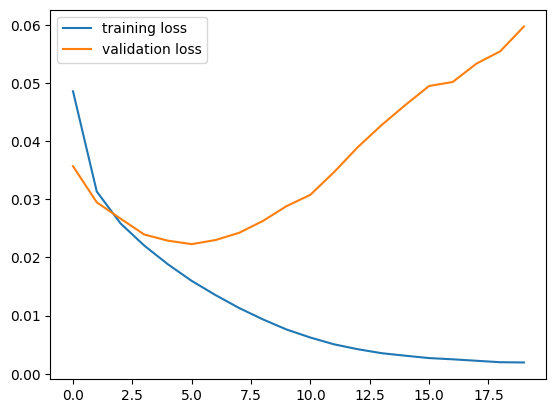

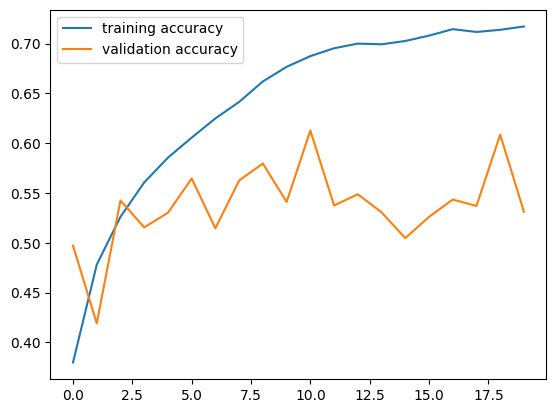

In [ ]:
# Plot the loss curve and training accuracy curve
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Get the predicted labels for the test set
y_pred = model.predict(X_test)

# Convert the predicted labels and true labels to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)
y_test_binary = y_test.astype(int)

# Calculate the accuracy
accuracy = (y_pred_binary == y_test_binary).all(axis=1).mean()
print('Accuracy for CNN is:', accuracy)

576/576 [==============================] - 2s 3ms/step
Accuracy for CNN is: 0.639933901340425


In [ ]:
# Calculate the precision, recall, and F1 score
precision = precision_score(y_test_binary, y_pred_binary, average='micro')
recall = recall_score(y_test_binary, y_pred_binary, average='micro')
f1 = f1_score(y_test_binary, y_pred_binary, average='micro')

print('Precision is:', precision)
print('Recall is:', recall)
print('F1 Score is :', f1)

Precision is: 0.66730499145948
Recall is: 0.6287835681076955
F1 Score is : 0.687835681076955


In [ ]:
hamming_loss = (n_classes - accuracy - precision - recall + (2 * f1_score)) / n_classes
print())

In [2]:
(100 - 63.99 - 66.73 - 62.87 + (2 * 68.78)) / 100

0.4397

## 2. AutoEncoder + MLP 

Autoencoders can be trained on large datasets of labeled proteins to learn protein sequences or structures that capture important functional information. By using an autoencoder for feature extraction and dimensionality reduction, we can reduce the complexity of the input data and remove noise or irrelevant features that might negatively impact the performance of the classification model. This can also help to improve the generalization performance of the model on new data.

***Advantage*** 

1. Autoencoders can learn nonlinear representations of the data and capture complex patterns or relationships

2. Autoencoders can handle missing data in protein datasets. 

Preprocess the sequence into numerical format

Source code in keras: https://keras.io/examples/generative/vae/

In this part, we also set the maximum length of sequence to 500 since autoencoder is computationally expensive.

Implement the model using Keras and Tensorflow

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_combined_normalized, y, test_size=0.2, random_state=66)

Construct the autoencoder model and train the autoencoder with your training data.

In [ ]:
# Define the autoencoder model
input_dim = x_train.shape[1]
encoding_dim = 256

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
history1 = autoencoder.fit(x_train, x_train, epochs=30, batch_size=64, shuffle=True, validation_split = 0.1)

Epoch 1/30
1037/1037 [==============================] - 5s 4ms/step - loss: 0.0113 - val_loss: 0.0020
Epoch 2/30
1037/1037 [==============================] - 3s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/30
1037/1037 [==============================] - 3s 3ms/step - loss: 9.8313e-04 - val_loss: 8.9519e-04
Epoch 4/30
1037/1037 [==============================] - 3s 3ms/step - loss: 8.5221e-04 - val_loss: 8.0847e-04
Epoch 5/30
1037/1037 [==============================] - 4s 4ms/step - loss: 7.6094e-04 - val_loss: 7.0166e-04
Epoch 6/30
1037/1037 [==============================] - 3s 3ms/step - loss: 6.8884e-04 - val_loss: 6.6535e-04
Epoch 7/30
1037/1037 [==============================] - 4s 4ms/step - loss: 6.2324e-04 - val_loss: 6.6540e-04
Epoch 8/30
1037/1037 [==============================] - 4s 3ms/step - loss: 5.7309e-04 - val_loss: 5.3229e-04
Epoch 9/30
1037/1037 [==============================] - 4s 4ms/step - loss: 5.2749e-04 - val_loss: 4.9867e-04
Epoch 10/30
1037/1037 [===

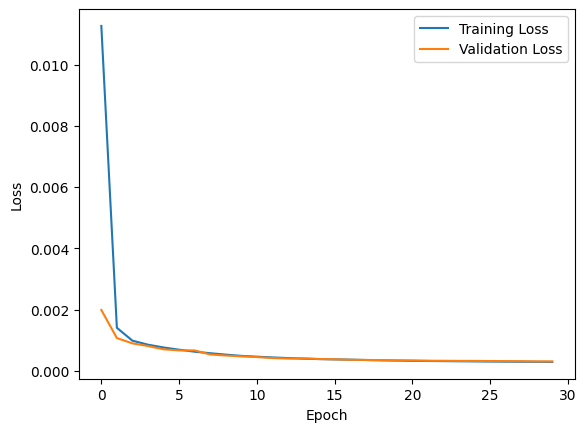

In [ ]:
# Plot loss curve
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Extract the encoded features from the trained autoencoder and then create an MLP model using the encoded features. Next, train the MLP model on the encoded features and labels.

In [ ]:
# Extract encoded features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Create the MLP model
mlp_input = Input(shape=(encoding_dim,))
hidden = Dense(256, activation='relu')(mlp_input)

# Add BatchNormalization layer
hidden = BatchNormalization()(hidden)
output = Dense(y_train.shape[1], activation='sigmoid')(hidden)

mlp = Model(mlp_input, output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the MLP model
history2 = mlp.fit(x_train_encoded, y_train, epochs=30, batch_size=64, shuffle=True, validation_split = 0.1)

576/576 [==============================] - 1s 1ms/step
Epoch 1/30
1037/1037 [==============================] - 6s 5ms/step - loss: 0.0501 - accuracy: 0.3457 - val_loss: 0.0415 - val_accuracy: 0.3975
Epoch 2/30
1037/1037 [==============================] - 4s 3ms/step - loss: 0.0378 - accuracy: 0.4028 - val_loss: 0.0367 - val_accuracy: 0.4199
Epoch 3/30
1037/1037 [==============================] - 4s 4ms/step - loss: 0.0343 - accuracy: 0.4421 - val_loss: 0.0341 - val_accuracy: 0.4291
Epoch 4/30
1037/1037 [==============================] - 4s 4ms/step - loss: 0.0323 - accuracy: 0.4680 - val_loss: 0.0332 - val_accuracy: 0.5189
Epoch 5/30
1037/1037 [==============================] - 4s 4ms/step - loss: 0.0309 - accuracy: 0.4832 - val_loss: 0.0321 - val_accuracy: 0.4944
Epoch 6/30
1037/1037 [==============================] - 4s 4ms/step - loss: 0.0297 - accuracy: 0.4944 - val_loss: 0.0309 - val_accuracy: 0.4979
Epoch 7/30
1037/1037 [==============================] - 3s 3ms/step - loss: 0.028

### Autoencoder + MLP result

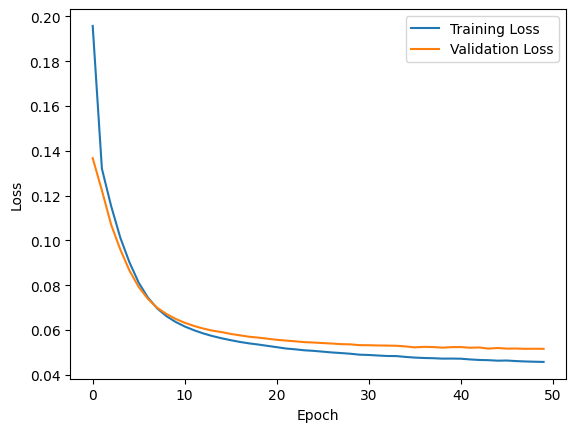

In [ ]:
# Plot loss curve
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

we can use the encoded sequences as input to a classifier model (e.g. logistic regression or a neural network) to predict protein function:

In [ ]:
# Predict the labels for the validation set
y_test_pred = mlp.predict(x_test_encoded)

# Convert probabilities to binary labels using a threshold (e.g., 0.5)
y_test_pred_bin = (y_test_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_test_pred_bin)
precision = precision_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)
recall = recall_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)

In [ ]:
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 58.3%
Precision: 69.98%
Recall: 63.27%
F1-score: 67.66%


## 3. RNN (Recurrent Neural Network)

RNNs are useful for this task because they can model the sequential dependencies between amino acids. Though RNNs may not achieve high accuracy. Nonetheless, RNNs is a useful tool for analyzing protein sequences and identifying potential functional domains. 

GRU is a variant of the traditional RNN that addresses the problem of vanishing gradients that can occur in the training of RNNs. It achieves this by introducing gating mechanisms that regulate the flow of information through the network. The gating mechanism in GRU is simpler than the one in LSTM, which makes it faster to train and computationally less expensive.

Protein function prediction is the task of inferring the function of a protein from its amino acid sequence. GRU is useful in protein function prediction because it can effectively model the sequential dependencies in the amino acid sequence, which are crucial for determining the protein's function. The gating mechanism in GRU allows the network to selectively focus on the relevant parts of the sequence and to ignore the irrelevant parts. This makes it possible to capture long-term dependencies in the sequence and to generate accurate predictions even for proteins with long and complex sequences.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=X_train.shape[1])) 
model.add(GRU(128, return_sequences=True))
model.add(GRU(128))
model.add(Dense(100, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

576/576 [==============================] - 2s 4ms/step
Epoch 1/40
1843/1843 [==============================] - 9s 4ms/step - loss: 0.0438 - accuracy: 0.3758 - val_loss: 0.0368 - val_accuracy: 0.3875
Epoch 2/40
1843/1843 [==============================] - 9s 5ms/step - loss: 0.0340 - accuracy: 0.4438 - val_loss: 0.0332 - val_accuracy: 0.4906
Epoch 3/40
1843/1843 [==============================] - 8s 5ms/step - loss: 0.0310 - accuracy: 0.4739 - val_loss: 0.0310 - val_accuracy: 0.5226
Epoch 4/40
1843/1843 [==============================] - 8s 4ms/step - loss: 0.0291 - accuracy: 0.4919 - val_loss: 0.0299 - val_accuracy: 0.4781
Epoch 5/40
1843/1843 [==============================] - 9s 5ms/step - loss: 0.0277 - accuracy: 0.5068 - val_loss: 0.0303 - val_accuracy: 0.4756
Epoch 6/40
1843/1843 [==============================] - 8s 4ms/step - loss: 0.0265 - accuracy: 0.5227 - val_loss: 0.0289 - val_accuracy: 0.5447
Epoch 7/40
1843/1843 [==============================] - 9s 5ms/step - loss: 0.025

### RNN result

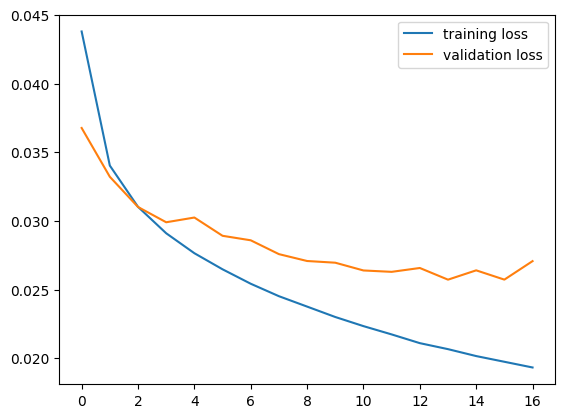

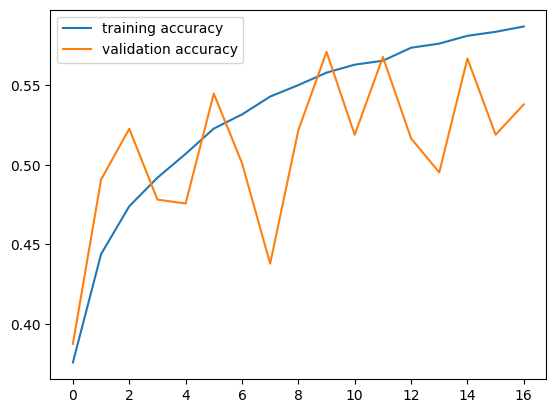

In [ ]:
# Plot the loss curve and training accuracy curve
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Predict the labels for the validation set
y_test_pred = model.predict(x_test_encoded)

# Convert probabilities to binary labels
y_test_pred_bin = np.round(y_test_pred)

accuracy = accuracy_score(y_test, y_test_pred_bin)
precision = precision_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)
recall = recall_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_test_pred_bin, average='weighted', zero_division=0)

576/576 [==============================] - 3s 5ms/step


In [ ]:
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 57.67%
Precision: 71.01%
Recall: 61.11%
F1-score: 66.41%
